This is the documentation of my code, summaries, and charts through which I analyzed the data provided to me.

In [207]:
#import libraries
import numpy as np
from pylab import *
import time
%matplotlib inline
import matplotlib.pyplot as plt
plt.show()
import pandas as pd
from datetime import datetime
from dateutil import parser
from sklearn.grid_search import GridSearchCV
sns.set_context("poster")


Read in the first csv

In [208]:
df=pd.read_csv("takehome_users.csv")
df.head()
df=df.rename(columns = {'object_id':'user_id'})
df.head()
len(df)


12000

While running through this dataset, I realized that I did not end up with 12,000 users at the end. From analyzing deeper, I found there are 3177 users who have registered but never logged into the site, and therefore are not in the engagement csv.

In [209]:
user_list = list(set(pd.read_csv("takehome_user_engagement.csv")['user_id']))

temp = []

for x in df.user_id:
    if x not in user_list:
        temp.append(x)
        
print len(temp)

3177


In [210]:
df2 = pd.read_csv("takehome_user_engagement.csv")
df2.head()
print "pre", len(set(df2['user_id']))


pre 8823


In [211]:
#calculate the week that the user logged in
week = np.empty(len(df2['time_stamp']))
for i in range(len(df2['time_stamp'])):
    week[i] = parser.parse(df2['time_stamp'].values[i]).isocalendar()[1]
print "post", len(set(df2['user_id']))

post 8823


In [212]:
#append the week to the dataframe
df2['week'] = week
df2.head()

#groupby week to see how many times user has logged on in one week
temp = df2.groupby(['user_id','week'])
temp = temp['visited'].apply(np.sum)
temp2 = temp.reset_index()
temp3 = temp2.groupby('user_id')

Now that we have the number of times a user has logged on in one week, we will now see if this has ever exceeded 3 times, because this is what defines an adopted user.

In [213]:
final = pd.DataFrame(temp3['visited'].apply(np.max)).reset_index()
final['target'] = final['visited'] >= 3
final.reset_index()
final['target'] = 0 + final['target']
final.head()

,user_id,visited,target
0,1,1,0
1,2,3,1
2,3,1,0
3,4,1,0
4,5,1,0


In [214]:
#merge to get the full pdf
full = pd.merge(final, df, on ='user_id')
full.head()

,user_id,visited,target,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803
1,2,3,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316
2,3,1,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525
3,4,1,0,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151
4,5,1,0,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240


Now that I have cleaned up the data given to me, I will create some of my own metrics that I think could be significant, such as the difference between creation start and last login, average adoption rate per organization, and whether the user who recommonded another user was an adopted user or not.

In [215]:
#make dummy variables for each creation source
for elem in full['creation_source'].unique():
    full[str(elem)] = full['creation_source'] == elem


In [216]:
#transform to see if user was recommended by another user
full['userinvite'] =  1- np.isnan(full['invited_by_user_id'])

#creates a variable to see if this user is an adopted user
active = np.empty(len(full['user_id']))

for i in range(len(full['user_id'])):
    if  math.isnan((full['invited_by_user_id'][i])):
        active[i] = 0
    else:
        user = full['invited_by_user_id'][i]
        indx = full[full['user_id'] == user].index.tolist()
        try:
            active[i] = full.loc[indx[0]]['target']
        except:
            active[i] = 0
        
full['activeinvite'] =  active


In [217]:
#date diff from last login to creation date
import datetime

#clean up the data to get consistent Pd.Timestamp types
full['creation_time2'] = [datetime.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S') for x in full['last_session_creation_time']]
full['creation_time2'] = [datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in full['creation_time2']]
full['creation_time'] = [datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in full['creation_time']]

#find the difference in time from creation to last login
full['diff'] = (full['creation_time2'] - full['creation_time']).dt.days
                


In [218]:
#adopted user rate from organization
orgdict = full.groupby('org_id')
orgdict = orgdict['target'].apply(np.mean).reset_index()

#find the matching organization adoption rate
orgrate = np.empty(len(full.org_id))
for i in range(len(full.org_id)):
    orgrate[i] = orgdict.values[full.org_id[i]][1]
    
#fill data frame
full['orgrate'] = orgrate

full.head()

,user_id,visited,target,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,GUEST_INVITE,ORG_INVITE,SIGNUP,PERSONAL_PROJECTS,SIGNUP_GOOGLE_AUTH,userinvite,activeinvite,creation_time2,diff,orgrate
0,1,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803,True,False,False,False,False,1,0,2014-04-21 23:53:30,-1,0.125000
1,2,3,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316,False,True,False,False,False,1,0,2014-03-30 23:45:04,135,0.081395
2,3,1,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525,False,True,False,False,False,1,1,2013-03-19 19:14:52,-1,0.260870
3,4,1,0,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151,True,False,False,False,False,1,1,2013-05-22 04:09:28,0,0.081395
4,5,1,0,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240,True,False,False,False,False,1,1,2013-01-22 05:14:20,4,0.272727


In [235]:
#split into adopted users and non adopted useres
fullrenew = full.query('target==True')
fullnotrenew = full.query('target==False')

#all variables we will consider
lcols = ['GUEST_INVITE', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'ORG_INVITE', 'diff','activeinvite','SIGNUP', 
         'PERSONAL_PROJECTS', 'SIGNUP_GOOGLE_AUTH', 'userinvite', 'orgrate']

Upon initial inspection of the data, I first wanted to look at the different creation sources to see if there is a significant difference in the adoption rates depending on the source.

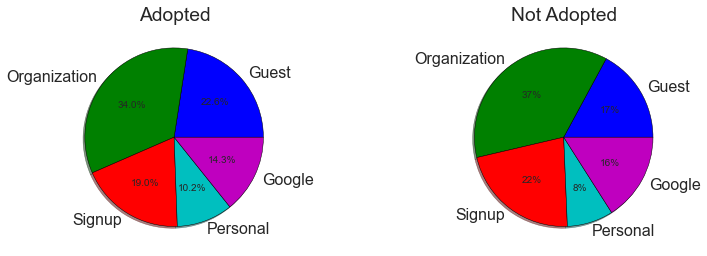

In [221]:
the_grid = GridSpec(2, 2)
labels = 'Guest', 'Organization', 'Signup', 'Personal', 'Google'
fracs1 = [np.mean(fullrenew['GUEST_INVITE']), np.mean(fullrenew['ORG_INVITE']), 
         np.mean(fullrenew['SIGNUP']), np.mean(fullrenew['PERSONAL_PROJECTS']),
         np.mean(fullrenew['SIGNUP_GOOGLE_AUTH'])]
pie(fracs1,labels=labels,shadow=True, startangle=90)

labels = 'Guest', 'Organization', 'Signup', 'Personal', 'Google'
fracs2 = [np.mean(fullnotrenew['GUEST_INVITE']), np.mean(fullnotrenew['ORG_INVITE']), 
         np.mean(fullnotrenew['SIGNUP']), np.mean(fullnotrenew['PERSONAL_PROJECTS']),
         np.mean(fullnotrenew['SIGNUP_GOOGLE_AUTH'])]
pie(fracs2,labels=labels,shadow=True, startangle=90)

plt.subplot(the_grid[0, 0], aspect=1)

plt.pie(fracs1, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title("Adopted")
plt.subplot(the_grid[0, 1], aspect=1)

plt.pie(fracs2, labels=labels, autopct='%.0f%%', shadow=True)
plt.title("Not Adopted")

Based on the pie chart, it is fairly difficult to see if there is a significant difference in the distribution of creation sources from those who are adopted users and those who are not. For further analysis, I have decided to run a two proportion t-test among adopted user samples and non adopted user samples.

In [222]:
from scipy import stats  


print stats.ttest_ind(fullrenew['SIGNUP'], fullnotrenew['SIGNUP'])
print stats.ttest_ind(fullrenew['PERSONAL_PROJECTS'], fullnotrenew['PERSONAL_PROJECTS'])
print stats.ttest_ind(fullrenew['GUEST_INVITE'], fullnotrenew['GUEST_INVITE'])
print stats.ttest_ind(fullrenew['ORG_INVITE'], fullnotrenew['ORG_INVITE'])


(-2.5103330316548464, 0.012079486183424049)
(2.2379543436119849, 0.02524889057672151)
(4.9427027058070463, 7.8465611184303486e-07)
(-1.8637316242345072, 0.062392602346958315)


From these results, I can see that only SIGNUP, PERSONAL_PROJECTS, and GUEST_INVITES have a statistically significant difference in the distribution of adopted users and non-adopted users. Therefore, only some creation sources affect if if a user will adopt the product.

Now we will use logistic regression to find the most important features to help the prediction in our model.

In [223]:

#Using GridSearchCV, it will choose the most optimal model after trying all different types of parameters given
def cv_optimize(clf, parameters, X, y, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters,  cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [229]:
"""
This function will take in the model,
parameters you want to optimize,
features you want to test in the model, 
the target variable
the target value that you want
mask- which represents which data you will use as training and which as testing
nfolds- number of cross validation
"""
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None,  n_folds=5):
    #selects only the features we want
    subdf=indf[featurenames]
    #this is the xmatrix
    X=subdf.values
    
    #gets the y array
    y=(indf[targetname].values==target1val)*1
    #separates into training and testing sets
    Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    
    #optimize using GridSearchCV
    clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [236]:
#Generating my mask to decide my testing and training
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(full.shape[0]), train_size=0.7)
mask=np.ones(full.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
print mask


[ True False  True ...,  True  True  True]


In [237]:
#Run the model 
from sklearn.linear_model import LogisticRegression
clflog, _, _, _, ytest = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0,100,1000]}, full,lcols, u'target',1, mask=mask)


BEST {'C': 0.001} 0.970369170984 [mean: 0.97037, std: 0.00195, params: {'C': 0.001}, mean: 0.96972, std: 0.00451, params: {'C': 0.01}, mean: 0.96972, std: 0.00451, params: {'C': 0.1}, mean: 0.97037, std: 0.00439, params: {'C': 1.0}, mean: 0.96988, std: 0.00414, params: {'C': 10.0}, mean: 0.97005, std: 0.00383, params: {'C': 100}, mean: 0.96988, std: 0.00414, params: {'C': 1000}]
############# based on standard predict ################
Accuracy on training data: 0.97
Accuracy on test data:     0.97
[[2170   32]
 [  42  403]]
########################################################


In [238]:

importances = pd.DataFrame(dict(feature=lcols, coef=clflog.coef_[0], abscoef=np.abs(clflog.coef_[0]))).sort('abscoef', ascending=False)
importances.set_index("feature", inplace=True)
importances.head(10)

,abscoef,coef
feature,,
diff,0.016621,0.016621
GUEST_INVITE,0.000000,0.000000
opted_in_to_mailing_list,0.000000,0.000000
enabled_for_marketing_drip,0.000000,0.000000
ORG_INVITE,0.000000,0.000000
activeinvite,0.000000,0.000000
SIGNUP,0.000000,0.000000
PERSONAL_PROJECTS,0.000000,0.000000
SIGNUP_GOOGLE_AUTH,0.000000,0.000000


From this model, it looks like difference is a very significant factor and it's hard to see if any other factors could be a good indicator. Therefore, I will try running the model without diff to understand what the following predictors could be.

In [240]:
lcols = ['GUEST_INVITE', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'ORG_INVITE','activeinvite','SIGNUP', 
         'PERSONAL_PROJECTS', 'SIGNUP_GOOGLE_AUTH', 'userinvite', 'orgrate']
clflogdiff, _, _, _, ytest = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0,100,1000]}, full,lcols, u'target',1, mask=mask)
lasso_importances=pd.DataFrame(dict(feature=lcols, coef=clflogdiff.coef_[0], abscoef=np.abs(clflogdiff.coef_[0]))).sort('abscoef', ascending=False)
lasso_importances.set_index("feature", inplace=True)
lasso_importances.head(10)

BEST {'C': 0.1} 0.838406735751 [mean: 0.83808, std: 0.00005, params: {'C': 0.001}, mean: 0.83808, std: 0.00005, params: {'C': 0.01}, mean: 0.83841, std: 0.00122, params: {'C': 0.1}, mean: 0.83760, std: 0.00153, params: {'C': 1.0}, mean: 0.83776, std: 0.00152, params: {'C': 10.0}, mean: 0.83776, std: 0.00152, params: {'C': 100}, mean: 0.83776, std: 0.00152, params: {'C': 1000}]
############# based on standard predict ################
Accuracy on training data: 0.84
Accuracy on test data:     0.83
[[2197    5]
 [ 437    8]]
########################################################


,abscoef,coef
feature,,
orgrate,4.772734,4.772734
SIGNUP,0.207301,-0.207301
ORG_INVITE,0.156782,-0.156782
SIGNUP_GOOGLE_AUTH,0.145219,-0.145219
GUEST_INVITE,0.091087,0.091087
activeinvite,0.086213,0.086213
opted_in_to_mailing_list,0.009463,0.009463
enabled_for_marketing_drip,0.000000,0.000000
PERSONAL_PROJECTS,0.000000,0.000000


Without difference masking the other variable importances, we can now see that the adoption rate by organization and the creation sources are fairly good indicators of predicting if a user will adopt or not.